In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import cv2
import os

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve 

In [9]:
#trying to use the combined csv's to do the split to see if the combined dataset works any better
# Load pre-paired CSVs (these guarantee diversity: 0, 1, 2, 3)
df_0 = pd.read_csv("Combined_Datasets_CSV/combined_open_eye_no_yawn.csv")   
df_1 = pd.read_csv("Combined_Datasets_CSV/combined_open_eye_yawn.csv")
df_2 = pd.read_csv("Combined_Datasets_CSV/combined_closed_eye_no_yawn.csv")   
df_3 = pd.read_csv("Combined_Datasets_CSV/combined_closed_eye_yawn.csv") 
   

# Combine all
full_df = pd.concat([df_0, df_1, df_2, df_3], ignore_index=True)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train/test
train_df, test_df = train_test_split(
    full_df,
    test_size=0.2, # train size = 80% and test size = 20%
    stratify=full_df['label'],  # Maintains 0, 1, 2, 3 distribution
    random_state=42 # for reproducibility
)

print("Train label distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df['label'].value_counts().sort_index())

#size for all images
image_resize = (128, 128)

def load_from_combined(df):
    X_eye, X_mouth, y, eye_files, mouth_files = [], [], [], [], []
    expected_h = image_resize[0]
    expected_w = image_resize[1] * 2  # combined width

    for _, row in df.iterrows():
        img = cv2.imread(row['combined_image_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # cv2 returns shape (h, w) for grayscale
        if img.shape != (expected_h, expected_w):
            # only resize if size differs (cv2.resize takes (w,h))
            img = cv2.resize(img, (expected_w, expected_h))

        left = img[:, :image_resize[1]]
        right = img[:, image_resize[1]:]

        X_eye.append(np.expand_dims(left.astype('float32') / 255.0, -1))
        X_mouth.append(np.expand_dims(right.astype('float32') / 255.0, -1))
        y.append(int(row['label']))
        eye_files.append(os.path.basename(row['combined_image_path']) + '_L')
        mouth_files.append(os.path.basename(row['combined_image_path']) + '_R')
    return np.array(X_eye), np.array(X_mouth), np.array(y), np.array(eye_files), np.array(mouth_files)

X_eye_train, X_mouth_train, y_train, eye_files_train, mouth_files_train = load_from_combined(train_df)
X_eye_test,  X_mouth_test,  y_test,  eye_files_test,  mouth_files_test  = load_from_combined(test_df)

# create binary labels for separate models
# label mapping: 0=open,no_yawn | 1=open,yawn | 2=closed,no_yawn | 3=closed,yawn
# eye: 0=open (labels 0,1) -> 0 ; 1=closed (labels 2,3) -> 1
y_eye_train  = (y_train >= 2).astype(int)
y_eye_test   = (y_test  >= 2).astype(int)

# mouth: 0=no_yawn (labels 0,2) -> 0 ; 1=yawn (labels 1,3) -> 1
y_mouth_train = (y_train % 2 == 1).astype(int)
y_mouth_test  = (y_test  % 2 == 1).astype(int)

# quick sanity prints
print("Train shapes:", X_eye_train.shape, X_mouth_train.shape, y_train.shape)
print("Binary label counts (eye,mouth):",
      np.bincount(y_eye_train), np.bincount(y_mouth_train))

Train label distribution:
label
0    160
1    160
2    160
3    160
Name: count, dtype: int64

Test label distribution:
label
0    40
1    40
2    40
3    40
Name: count, dtype: int64
Train shapes: (640, 128, 128, 1) (640, 128, 128, 1) (640,)
Binary label counts (eye,mouth): [320 320] [320 320]


In [10]:
#model architecture for eye state classification
def build_eye_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

eye_model = build_eye_cnn()

history_eye = eye_model.fit(
    X_eye_train, y_eye_train,
    validation_data=(X_eye_test, y_eye_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.4969 - loss: 0.7362 - val_accuracy: 0.5750 - val_loss: 0.6665
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.6766 - loss: 0.5874 - val_accuracy: 0.6438 - val_loss: 0.4954
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.8438 - loss: 0.3826 - val_accuracy: 0.7500 - val_loss: 0.4206
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.9438 - loss: 0.2316 - val_accuracy: 0.9812 - val_loss: 0.1061
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.9844 - loss: 0.0679 - val_accuracy: 0.9875 - val_loss: 0.0405


In [11]:
#model architecture for mouth state classification
def build_mouth_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

mouth_model = build_mouth_cnn()

history_mouth = mouth_model.fit(
    X_mouth_train, y_mouth_train,
    validation_data=(X_mouth_test, y_mouth_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 420ms/step - accuracy: 0.6297 - loss: 0.6726 - val_accuracy: 0.8813 - val_loss: 0.4179
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8375 - loss: 0.3693 - val_accuracy: 0.9000 - val_loss: 0.2516
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.8953 - loss: 0.2785 - val_accuracy: 0.9375 - val_loss: 0.2208
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - accuracy: 0.9219 - loss: 0.2276 - val_accuracy: 0.9250 - val_loss: 0.1983
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.9234 - loss: 0.2002 - val_accuracy: 0.9438 - val_loss: 0.1906


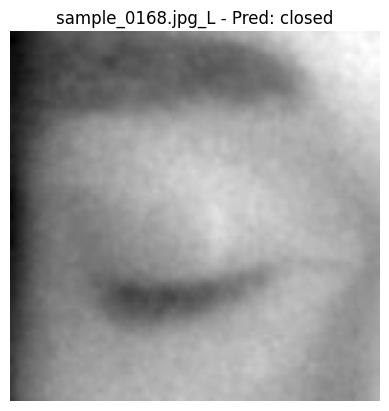

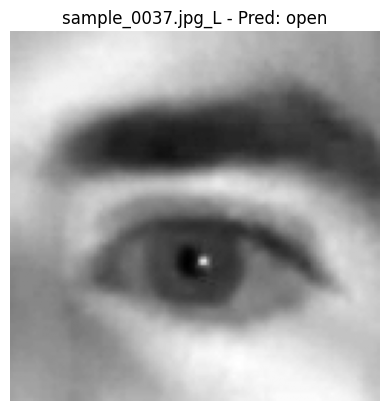

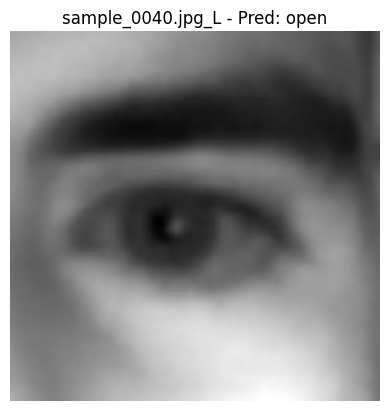

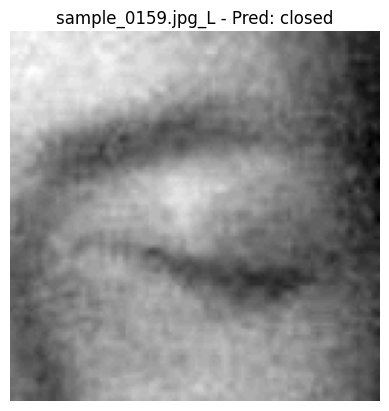

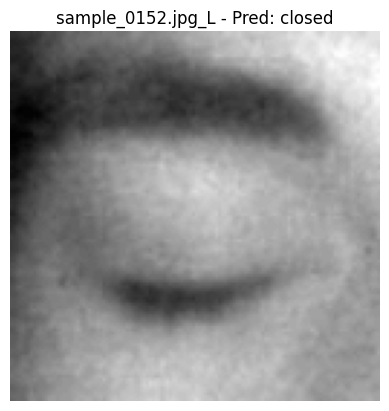

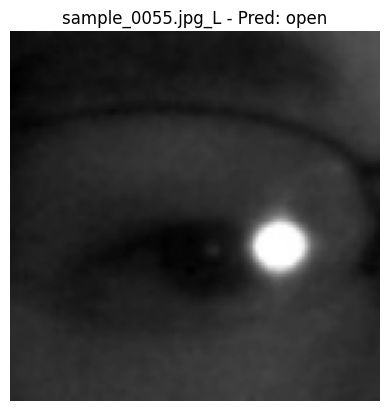

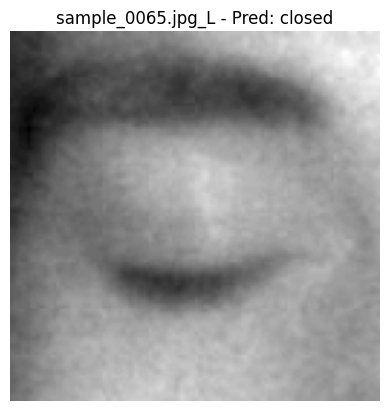

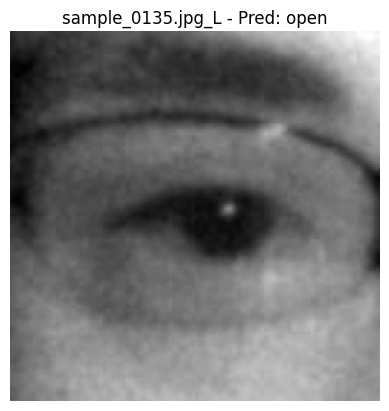

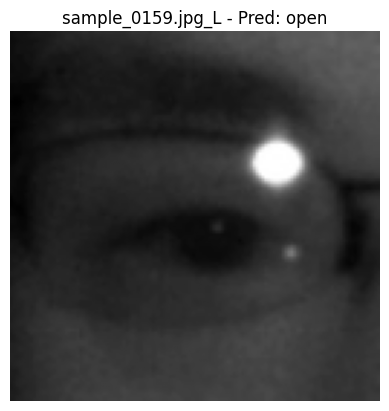

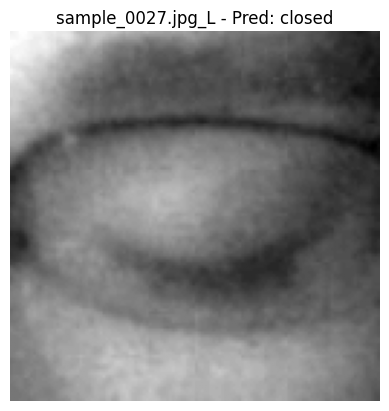

In [12]:
#looking to see how the eye test images are being classified by theeye state detection model
# 0 = open, 1 = closed
import matplotlib.pyplot as plt

for i in range(10):   # show first 10
    prob_closed = eye_model.predict(np.array([X_eye_test[i]]), verbose=0)[0][0]
    pred = 1 if prob_closed >= 0.5 else 0

    plt.imshow(X_eye_test[i].squeeze(), cmap='gray')
    plt.title(f"{eye_files_test[i]} - Pred: {'closed' if pred==1 else 'open'}")
    plt.axis('off')
    plt.show()

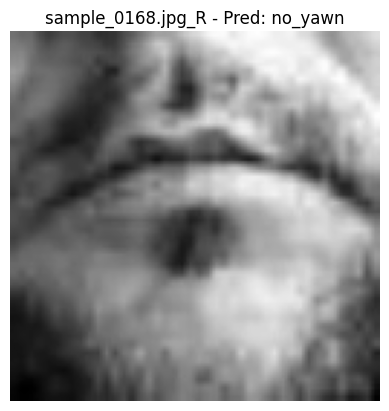

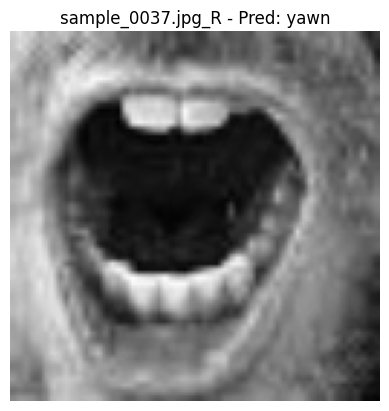

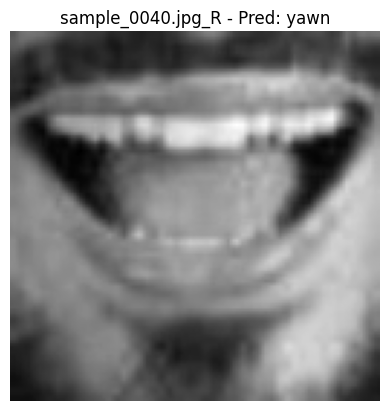

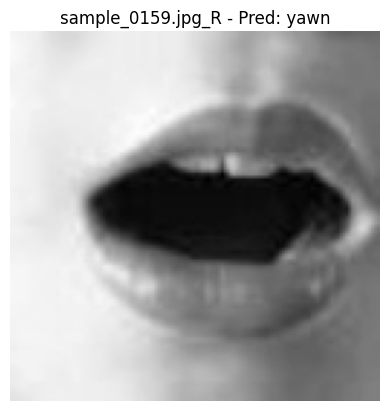

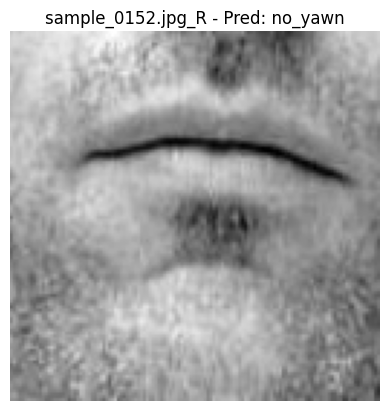

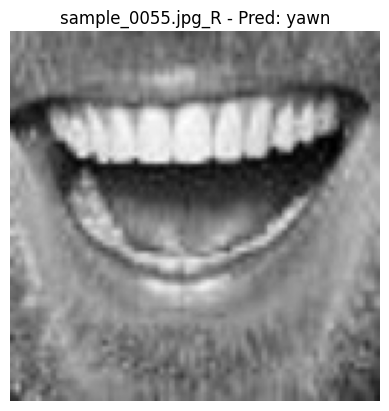

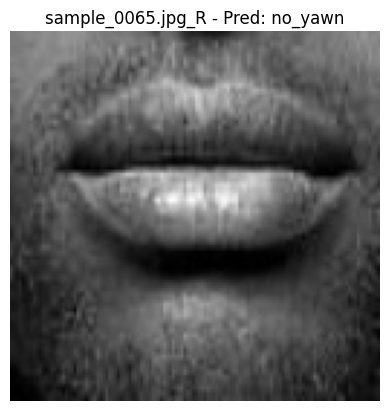

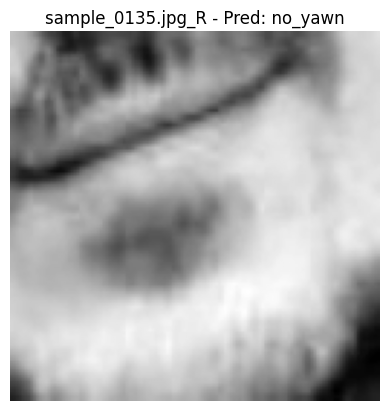

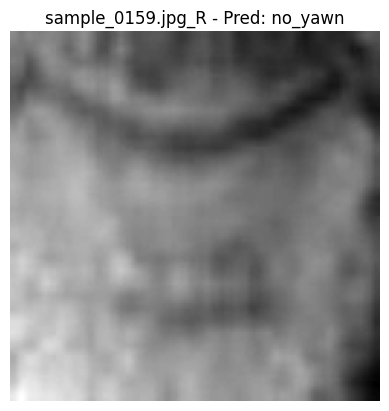

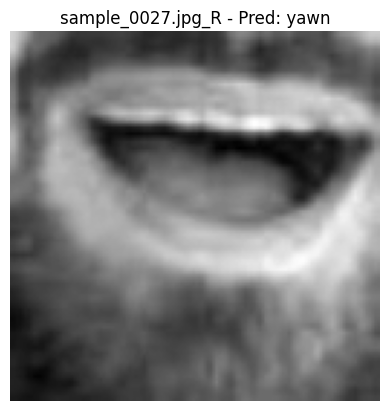

In [13]:
# looking to see how the test mouth images are being classified by the mouth state detection model
# 0 = no yawn, 1 = yawn


import matplotlib.pyplot as plt

for i in range(10):   # show first 10
    prob_open = mouth_model.predict(np.array([X_mouth_test[i]]), verbose=0)[0][0]
    pred = 1 if prob_open >= 0.5 else 0 # 0 - no yawn, 1 - yawn

    plt.imshow(X_mouth_test[i].squeeze(), cmap='gray')
    plt.title(f"{mouth_files_test[i]} - Pred: {'yawn' if pred==1 else 'no_yawn'}")
    plt.axis('off')
    plt.show()

In [14]:
#model architecture for mapping outputs to their final classes and the corresponding messages

def combine_hard_labels(eye_model, mouth_model, eye_img, mouth_img):

    # Predict raw probabilities
    p_eye_closed = eye_model.predict(np.array([eye_img]), verbose=0)[0][0] #probability eyes = closed
    p_mouth_open = mouth_model.predict(np.array([mouth_img]), verbose=0)[0][0] #probability mouth = open

    # Convert to binary labels
    eye_label = 1 if p_eye_closed >= 0.5 else 0 #1 = closed, 0 = open
    mouth_label = 1 if p_mouth_open >= 0.5 else 0 #1 = yawn, 0 = no yawn

    # Correct class mapping based on your definition
    if eye_label == 0 and mouth_label == 0:
        final_class = 0  # eyes open mouth closed
    elif eye_label == 0 and mouth_label == 1:
        final_class = 1 # eyes open mouth open
    elif eye_label == 1 and mouth_label == 0:
        final_class = 2 # eyes closed mouth closed
    elif eye_label == 1 and mouth_label == 1:
        final_class = 3 # eyes closed mouth open
      
    # Label dictionary
    labels = {
        0: "eyes_open__mouth_closed",
        1: "eyes_open__yawning",
        2: "eyes_closed__mouth_closed",
        3: "eyes_closed__yawning"
    }

    # message dictionary for the classes
    messages = {
        0: "Good job, you are alert!",
        1: "Getting sleepy there? Consider taking a break.",
        2: "🚨 ALERT ALERT 🚨",
        3: "That was a big yawn, take a break!"
    }
    
    #print the messages
    print(messages[final_class])
    
    return final_class, labels[final_class]

In [15]:
# storing the outputs from the mapping function

combined_pred = []

for i in range(len(X_eye_test)):
    final_class, final_label = combine_hard_labels(
        eye_model,
        mouth_model,
        X_eye_test[i],      # <--- numpy array
        X_mouth_test[i]     # <--- numpy array
    )

    combined_pred.append({
        "eye_file": eye_files_test[i],
        "mouth_file": mouth_files_test[i],
        "predicted_class": final_class,
        "predicted_label": final_label
    })

🚨 ALERT ALERT 🚨
Getting sleepy there? Consider taking a break.
Getting sleepy there? Consider taking a break.
That was a big yawn, take a break!
🚨 ALERT ALERT 🚨
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Good job, you are alert!
That was a big yawn, take a break!
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Good job, you are alert!
Good job, you are alert!
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
That was a big yawn, take a break!
🚨 ALERT ALERT 🚨
🚨 ALERT ALERT 🚨
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
That was a big yawn, take a break!
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
🚨 ALERT ALERT 🚨
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
Getting sleepy there? Consider takin

🚨 ALERT ALERT 🚨


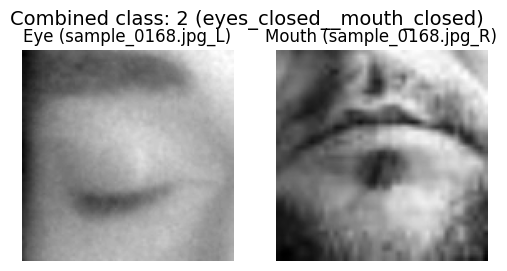

Getting sleepy there? Consider taking a break.


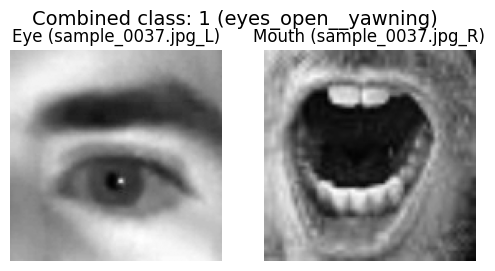

Getting sleepy there? Consider taking a break.


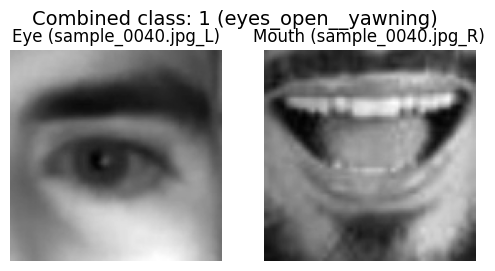

That was a big yawn, take a break!


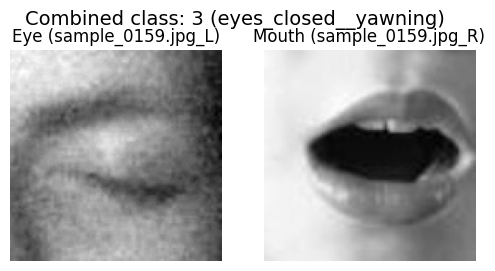

🚨 ALERT ALERT 🚨


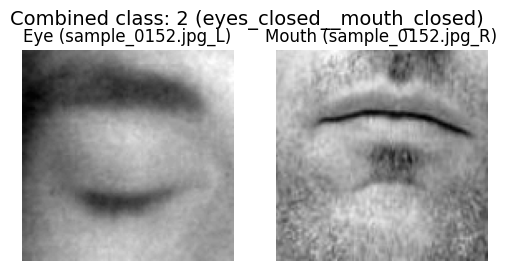

Getting sleepy there? Consider taking a break.


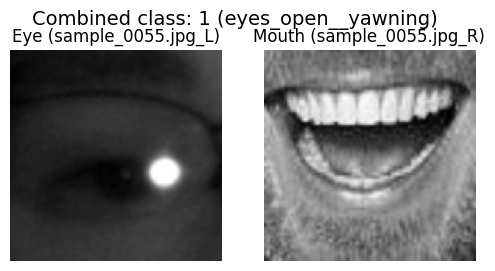

🚨 ALERT ALERT 🚨


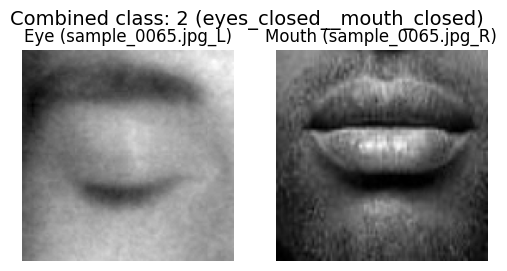

Good job, you are alert!


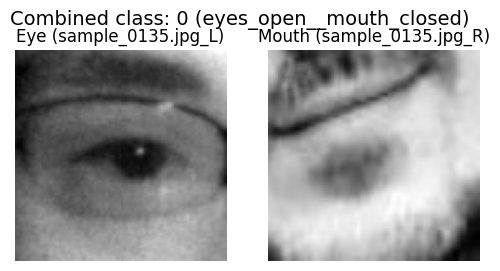

Good job, you are alert!


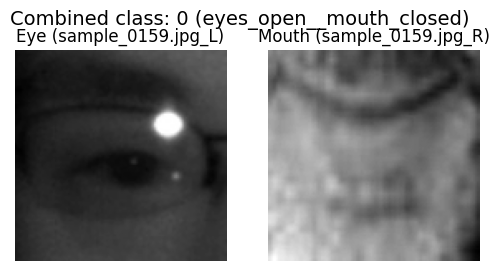

That was a big yawn, take a break!


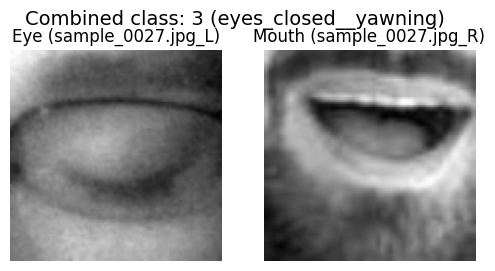

In [16]:
import matplotlib.pyplot as plt

for i in range(10):  # show first 10 pairs
    final_class, final_label = combine_hard_labels(
        eye_model, mouth_model,
        X_eye_test[i], X_mouth_test[i]
    )

    plt.figure(figsize=(6,3))

    # Eye
    plt.subplot(1,2,1)
    plt.imshow(X_eye_test[i].squeeze(), cmap='gray')
    plt.title(f"Eye ({eye_files_test[i]})")
    plt.axis('off')

    # Mouth
    plt.subplot(1,2,2)
    plt.imshow(X_mouth_test[i].squeeze(), cmap='gray')
    plt.title(f"Mouth ({mouth_files_test[i]})")
    plt.axis('off')

    plt.suptitle(f"Combined class: {final_class} ({final_label})", fontsize=14)
    plt.show()

🚨 ALERT ALERT 🚨


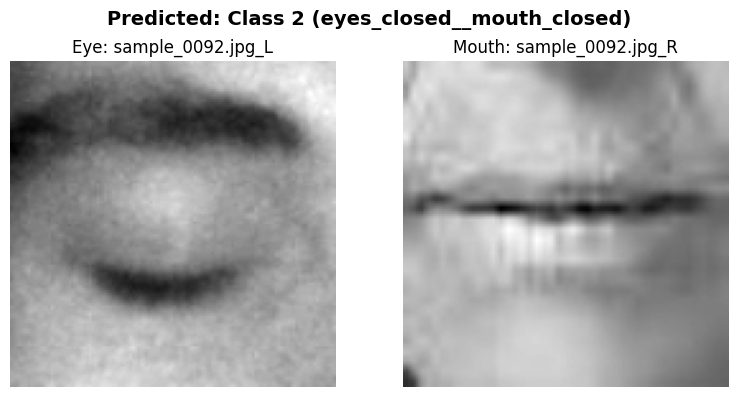

Ground Truth - Eye label: 1, Mouth label: 0


In [35]:
# using a random eye mouth pairing to test the combined model

import random

# Pick a random index
random_idx = random.randint(0, len(X_eye_test) - 1)

# Get random eye and mouth
random_eye = X_eye_test[random_idx]
random_mouth = X_mouth_test[random_idx]
random_eye_file = eye_files_test[random_idx]
random_mouth_file = mouth_files_test[random_idx]

# Get predictions
final_class, final_label = combine_hard_labels(
    eye_model, mouth_model,
    random_eye, random_mouth
)

#display the results of the random pairing
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(random_eye.squeeze(), cmap='gray')
axes[0].set_title(f"Eye: {random_eye_file}")
axes[0].axis('off')

axes[1].imshow(random_mouth.squeeze(), cmap='gray')
axes[1].set_title(f"Mouth: {random_mouth_file}")
axes[1].axis('off')

fig.suptitle(f"Predicted: Class {final_class} ({final_label})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print ground truth for comparison
print(f"Ground Truth - Eye label: {y_eye_test[random_idx]}, Mouth label: {y_mouth_test[random_idx]}")